# Importing Necessary Libraries:

In [52]:
import pandas as pd
import numpy as np

import time
import pickle

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from collections import Counter

import hdbscan
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

school_data = pd.read_csv('data_files/BASE_clean_college_score_card_data.csv', index_col=0)

# Verifying Integrity of Numerical Columns:

In [23]:
# Changing categorical data values to numerical. Here we are mapping states to digits 0-58 (As they
# include more than just the 50 typical states, like BC and Puerto Rico)

# The same is being done for the cities, where they will mappes from 0-2k
state_index_list = []
for i, state in enumerate(set(school_data['STABBR'])):
    state_index = (state, i)
    state_index_list.append(state_index)
    
state_dictionary = dict(state_index_list)
state_dictionary

city_index_list = []
for i, city in enumerate(set(school_data['CITY'])):
    city_index = (city, i)
    city_index_list.append(city_index)
    
city_dictionary = dict(city_index_list)
city_dictionary

school_data.replace({'CITY': city_dictionary, 'STABBR': state_dictionary}, inplace=True)

# For clustering
numeric_school_data = school_data.iloc[:,1:]

#------------------------------------------------------------------------------
# This next section will impute the data, and verify the integrity of the data.
#------------------------------------------------------------------------------

# Resolving any NaN values using Imputation
# Credit to O.rka at https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(numeric_school_data))
imputed_DF.columns = numeric_school_data.columns
imputed_DF.index = numeric_school_data.index

def verify_data(dataframe):
    # Check for incorrect column types
    for i in range(len(dataframe.dtypes)):
        if dataframe.dtypes[i] != dataframe.dtypes[1]:
            print(dataframe.dtypes[i])

    print("No other bad dtypes.")

    # Check for NaN values
    dataframe.isnull().values.any()

    print("No other NaN values.")

    print(np.where(np.isnan(dataframe)))
    
    # Checking each value for infinite values
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.index)):
            if np.isfinite(dataframe.iloc[j,i]) == False:
                print(j,i)
                print(dataframe.iloc[j,i])

    print("No other non-finite values.")
    
    for col in dataframe.columns:
        if len(dataframe[col].unique()) == 1:
            print("WARNING:", col, "has only 1 unique value (0 variance) and may cause issues when scaling")
    print("No other 0 variance columns found.\n")
    
verify_data(imputed_DF)

# Not sure why curroper remained in our data after it was removed, removing it again.
imputed_DF = imputed_DF.drop(columns=['CURROPER'])
verify_data(imputed_DF)

scaled_imputed_df = pd.DataFrame(scale(imputed_DF))
scaled_imputed_df.columns = imputed_DF.columns
scaled_imputed_df
        

No other bad dtypes.
No other NaN values.
(array([], dtype=int64), array([], dtype=int64))
No other non-finite values.
No other 0 variance columns found.

No other bad dtypes.
No other NaN values.
(array([], dtype=int64), array([], dtype=int64))
No other non-finite values.
No other 0 variance columns found.



CITY    STABBR      HCM2   PREDDEG   HIGHDEG   CONTROL  \
0    -0.096367  1.660621 -0.098265  1.081687  1.299137 -1.313341   
1     0.817616  1.660621 -0.098265  1.081687  1.299137 -1.313341   
2    -0.270995  1.660621 -0.098265  1.081687  1.299137 -0.120011   
3     0.497933  1.660621 -0.098265  1.081687  1.299137 -1.313341   
4    -0.270995  1.660621 -0.098265  1.081687  1.299137 -1.313341   
5     0.295139  1.660621 -0.098265  1.081687  1.299137 -1.313341   
6    -0.494914  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
7    -0.089325  1.660621 -0.098265  1.081687  0.549992 -1.313341   
8    -0.270995  1.660621 -0.098265  1.081687  1.299137 -1.313341   
9    -1.076539  1.660621 -0.098265  1.081687  1.299137 -1.313341   
10    0.817616  1.660621 -0.098265  1.081687  0.549992 -0.120011   
11   -0.018911  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
12   -0.270995  1.660621 -0.098265  1.081687  1.299137  1.073319   
13    1.461206  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
14   -0.578003  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
15   -0.270995  1.660621 -0.098265  1.081687  1.299137 -0.120011   
16   -1.400447  1.660621 -0.098265 -0.823221 -0.199152 -1.313341   
17    0.114877  1.660621 -0.098265 -0.823221 -0.948297  1.073319   
18    0.386678  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
19   -0.097775  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
20    0.995061  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
21    0.817616  1.660621 -0.098265 -0.823221  1.299137  1.073319   
22   -0.270995  1.660621 -0.098265  1.081687  0.549992 -0.120011   
23   -0.797697  1.660621 -0.098265  1.081687  1.299137 -0.120011   
24    0.497933  1.660621 -0.098265 -0.823221 -0.199152 -1.313341   
25    0.361329  1.660621 -0.098265 -0.823221 -0.948297 -1.313341   
26    0.696503  1.660621 -0.098265  1.081687  1.299137 -1.313341   
27   -0.207622  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
28    0.817616  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
29    0.941546  1.660621 -0.098265  0.129233 -0.199152 -1.313341   
...        ...       ...       ...       ...       ...       ...   
6662 -1.417346 -0.023304 -0.098265 -1.775675 -1.697442  1.073319   
6663  1.738640 -0.023304 -0.098265 -1.775675 -1.697442  1.073319   
6664 -0.114675 -0.023304 -0.098265 -1.775675 -1.697442  1.073319   
6665 -1.455370 -0.023304 -0.098265 -1.775675 -1.697442  1.073319   
6666 -1.446921 -0.023304 -0.098265 -1.775675 -1.697442  1.073319   
6667  1.362626  0.737178 -0.098265 -1.775675 -1.697442  1.073319   
6668 -1.599016  0.737178 -0.098265 -1.775675 -1.697442  1.073319   
6669  1.289395  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6670 -0.514630  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6671 -0.424499  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6672 -1.096255  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6673 -1.418755  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6674  1.100683  0.465577 -0.098265 -1.775675 -1.697442  1.073319   
6675  1.437265 -1.435629 -0.098265 -1.775675 -1.697442  1.073319   
6676  1.016186  0.682858 -0.098265 -1.775675 -1.697442 -0.120011   
6677  1.672451  0.845818 -0.098265 -1.775675 -1.697442 -0.120011   
6678  0.076853  0.193976 -0.098265 -1.775675 -1.697442 -0.120011   
6679  0.776776  1.714941 -0.098265 -1.775675 -1.697442 -0.120011   
6680 -0.514630  0.465577 -0.098265 -1.775675 -1.697442 -0.120011   
6681  1.413324 -1.109708 -0.098265 -1.775675 -1.697442 -0.120011   
6682 -1.473678  0.845818 -0.098265 -1.775675 -1.697442 -0.120011   
6683 -1.294825  1.551980 -0.098265 -1.775675 -1.697442 -0.120011   
6684 -0.703341  0.791498 -0.098265 -1.775675 -1.697442 -0.120011   
6685 -0.030177  1.714941 -0.098265 -1.775675 -1.697442 -0.120011   
6686 -1.568034 -1.055388 -0.098265 -1.775675 -1.697442  1.073319   
6687 -1.548318 -0.620826 -0.098265 -1.775675 -1.697442  1.073319   
6688 -0.469565 -1.055388 -0.098265 -1.775675 -1.697442  1.073319  

# Creating PCA Model and Showing Variances:

The first 20 components explain 58.386% of the variance in this data.
(0.9009065195715455, 63)

These are the principle components that explain more tha 1% of variance
[0.16805876031913428, 0.07793916938345608, 0.049890792652243825, 0.041064751613734136, 0.024979745235420167, 0.023671366027702107, 0.021670284767720142, 0.020765776873705174, 0.018263485722233602, 0.017283539940596275, 0.016218119244726253, 0.014257744708597928, 0.013180267141982237, 0.012632313588658559, 0.01204969529457748, 0.011990684116808328, 0.010263327269596225, 0.01011050359313668]


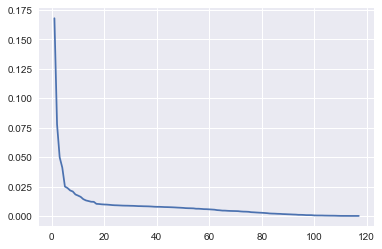

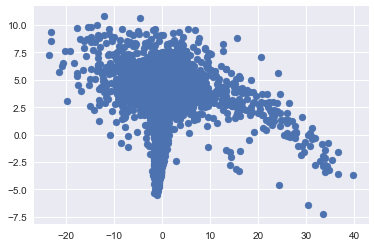

PC0       PC1       PC2       PC3  \
Alabama A & M University            -14.761196  8.874350  3.780629 -0.685040   
University of Alabama at Birmingham   5.367940  4.707486  3.900262 -0.864720   
Amridge University                   -0.755498  0.349884  0.129016  0.254224   
University of Alabama in Huntsville  11.696237  4.211047  6.251628 -0.385960   
Alabama State University            -13.912052  8.406995  3.764582 -1.029000   

                                          PC4       PC5       PC6       PC7  \
Alabama A & M University             4.185767  1.267260  2.065133  1.207074   
University of Alabama at Birmingham  0.039546  3.271173  0.657202 -0.173531   
Amridge University                   4.437594  3.430966 -4.557889 -0.562029   
University of Alabama in Huntsville -0.690747  5.943767  0.154815  0.232202   
Alabama State University             5.506200  0.205088  2.793087  0.962113   

                                          PC8       PC9  ...      PC53  \
Alabama A & M University             2.464418 -3.666358  ... -1.036370   
University of Alabama at Birmingham -0.542162 -1.378490  ... -0.333062   
Amridge University                  -0.880642  2.398155  ... -1.214297   
University of Alabama in Huntsville -1.918800 -1.360917  ... -0.357746   
Alabama State University             4.182398 -3.935242  ...  0.115920   

                                         PC54      PC55      PC56      PC57  \
Alabama A & M University            -0.038658 -1.361671  0.112319 -0.390343   
University of Alabama at Birmingham  0.457409 -0.581440  0.226715 -0.673676   
Amridge University                  -1.475370  0.103213 -0.965670  1.658775   
University of Alabama in Huntsville  0.963833 -0.889569 -1.244289 -0.201485   
Alabama State University            -0.601914  0.362026  2.454019  0.108143   

                                         PC58      PC59      PC60      PC61  \
Alabama A & M University             0.073657 -0.290826 -0.170203 -0.200840   
University of Alabama at Birmingham  0.455129 -0.797175  0.286771  0.636324   
Amridge University                  -0.972324 -0.261562 -0.131517 -0.125538   
University of Alabama in Huntsville  0.739844  0.299132  0.047931 -0.041264   
Alabama State University            -1.534748  2.025180  0.148261  0.040396   

                                         PC62  
Alabama A & M University             1.616926  
University of Alabama at Birmingham -0.320435  
Amridge University                   1.934534  
University of Alabama in Huntsville -0.868886  
Alabama State University             1.533953  

[5 rows x 63 columns]

In [3]:
pca_model = PCA()
snsd_PCA = pca_model.fit_transform(scaled_imputed_df)

def sum_variance_explained(pca_model, pca_component_limit, verbose=True):
    '''Finds the total variance explained within n number of components'''
    sum_of_components = 0
    for i in range(pca_component_limit):
        sum_of_components += pca_model.explained_variance_ratio_[i]
    if verbose == True:
        print("The first ", pca_component_limit, " components explain ", 
              round(sum_of_components*100, 3), "% of the variance in this data.", sep = "")
    return sum_of_components
    
def find_optimal_components(pca_model, tolerance):
    '''Finds the number of componenets needed to provide enough variance within the tolerance amount'''
    limit = 0
    sum_of_components = sum_variance_explained(pca_model, 0, verbose=False)
    while (1.00-sum_of_components > tolerance):
        sum_of_components = sum_variance_explained(pca_model, limit, verbose=False)
        limit += 1
    return sum_of_components, limit

# Examples of the functions defined above
sum_variance_explained(pca_model, 20)
print(find_optimal_components(pca_model, .10))

num_components_needed = find_optimal_components(pca_model, .10)[1]
    
# Plotting the explained variance for each principle component
list_of_PCA_variances = []
for i in range(len(pca_model.explained_variance_ratio_)):
    list_of_PCA_variances.append(pca_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 1% of variance")
components_to_use = []
for variance in list_of_PCA_variances:
    if variance > 0.01:
        components_to_use.append(variance)
print(components_to_use)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_model.explained_variance_ratio_), 
                     len(scaled_imputed_df.columns)), list_of_PCA_variances)
plt.show()
plt.scatter(snsd_PCA[:,0],snsd_PCA[:,1])
plt.show()

column_names = []
for i in range(num_components_needed):
    header = "PC"
    component_number = str(i)
    column_names.append(header + component_number)

PCA_DF = pd.DataFrame(snsd_PCA[:,0:len(column_names)], columns=column_names, 
                      index=list(school_data.iloc[:,0]))

# Show the new points in R^n where n=dimensions left after PCA
PCA_DF.head()


# Running the Spectral Clustering Method:
Major problem: My computer cannot run the algorithm on all schools without blowing up, it takes over 2 hours 
with 5000 schools out of the nearly 6000+

In [4]:
# Example spectral clustering models, variables can be changed.
start = time.time()
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=0).fit(PCA_DF.iloc[0:500,:])
print("Clusters:", set(clustering.labels_))
end = time.time()
print("\nTime taken: ", end="")
print(end - start)

/home/owen/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Clusters: {0, 1, 2, 3, 4}

Time taken: 11.844664335250854


# Testing KMeans

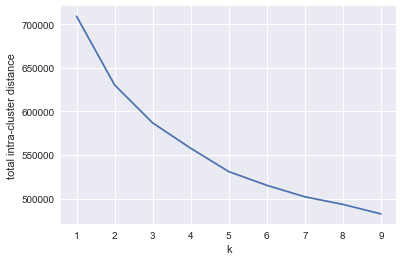

In [5]:
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(PCA_DF)
    scores.append(-model.score(PCA_DF))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

Unfortunately, we do not see a very clear drop-off here. The intracluster distance does not have a drop off point, which may indicate that this data is not clustered nicely. We may have some non-concave shapes.

# Testing DBSCAN 

In [6]:
def test_dbscan(eps, min_samples):
    db_model = DBSCAN(eps=eps, min_samples=min_samples)
    db_model.fit(PCA_DF)
    y_pred = db_model.fit_predict(PCA_DF)
    labels = db_model.labels_
    return labels

eps = np.linspace(1,10, 19)
for i in eps:
    current_set = set(test_dbscan(i, 30))
    print(current_set, i)
    if i > 100 and len(current_set) == 1:
        break

{0, -1} 1.0
{0, 1, -1} 1.5
{0, 1, -1} 2.0
{0, 1, 2, -1} 2.5
{0, 1, 2, -1} 3.0
{0, 1, -1} 3.5
{0, -1} 4.0
{0, 1, -1} 4.5
{0, 1, 2, -1} 5.0
{0, 1, 2, -1} 5.5
{0, 1, 2, -1} 6.0
{0, 1, 2, 3, -1} 6.5
{0, 1, 2, 3, -1} 7.0
{0, 1, 2, -1} 7.5
{0, 1, 2, -1} 8.0
{0, 1, -1} 8.5
{0, 1, -1} 9.0
{0, 1, -1} 9.5
{0, 1, -1} 10.0


# Assume the Clusters are Created Correctly

In [7]:
db_model = DBSCAN(eps=7.0, min_samples=30)
db_model.fit(PCA_DF)
y_pred = db_model.fit_predict(PCA_DF)
labels = db_model.labels_
# Run, find cluster, focus on cluster data, cluster again, find nearest cluster, repeat for n<10 schools?

In [8]:
data = PCA_DF

cluster_map = pd.DataFrame()
cluster_map['school'] = data.index.values
cluster_map['cluster'] = labels
# eps = 5.5
# 0 ?
# 1 Technical schools?
# 2 Truck driving, vocational
# 3 Cosmetology schools
# 4 california? something else?
# 5 Argosy
# 6 Jewish
# 7 indiana
# 8 ? 
# 9 beauty school
# 10 university of phoenix
# 11 nursing
# 12 golfing
# 13 recording, productions

# Find average earnings for clusters, locations

current_cluser = cluster_map[cluster_map['cluster'] == 1]
#print(school_data.iloc[current_cluser.index,:].describe()['MD_EARN_WNE_P10'])
#print(school_data.iloc[current_cluser.index,:].describe())
#school_data.iloc[current_cluser.index,:]

# Good cluster, 2.5, 10 high earnings, cluster 1

# Testing with HDBSCAN

In [41]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=30)
cluster_labels = clusterer.fit_predict(PCA_DF)
hdlabels = clusterer.labels_
set(hdlabels)
# Only 2 clusters with my data using 50, 30, what happened? Why do we have different scaling for PCA?
# Changing values to give us more clusters to analyze different possibilities

{-1, 0, 1, 2, 3, 4, 5}

In [42]:
clusterList = list(zip(hdlabels, PCA_DF.index.values))
len(clusterList)

6692

In [43]:
# Removes noise cluster
for i in sorted(clusterList, key=lambda x: x[0]):
    if i[0] < 0:
        clusterList.remove(i)
        
len(clusterList)

3856

In [44]:
sorted_ClusterList = sorted(clusterList, key=lambda x: x[0])

In [45]:
# this cell creates a rotating 3D scatter plot of the top 3 principal components in a pop up window
from matplotlib import interactive
from PyQt5 import QtGui, QtCore
interactive(True)
%matplotlib qt

num_clusters = clusterer.labels_.max()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.9, 0.9, 0.9)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
ax.scatter(PCA_DF.PC1, PCA_DF.PC2, PCA_DF.PC3, linewidth=0, 
                  c=cluster_member_colors, alpha=0.4)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("Hierarchical DBSCAN w/ %d Clusters" % num_clusters)

for angle in range(0, 360):
    ax.view_init(10, angle)
    plt.draw()
    plt.pause(.0001);
# Why does secondary window popup?

<Figure size 432x288 with 0 Axes>

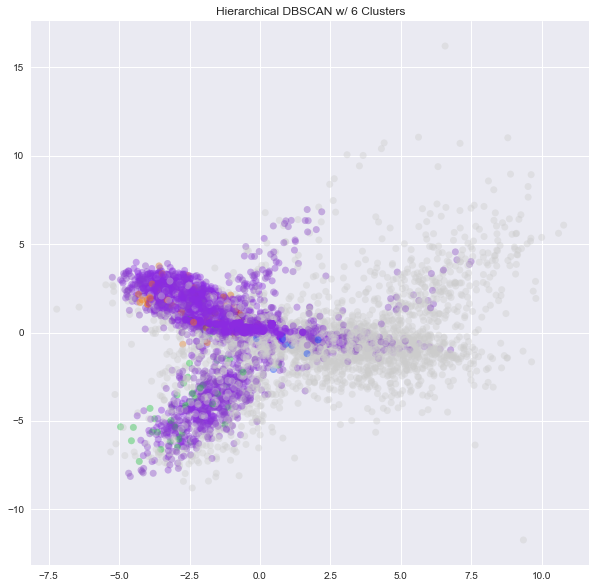

In [46]:
#2D scatter plot of top 2 PC's
# What do the white, orange, and blue spots correspond to?
%matplotlib inline
plt.figure(figsize=(10, 10))

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.8, 0.8, 0.8)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(PCA_DF.PC1, PCA_DF.PC2,  linewidth=0, c=cluster_member_colors, alpha=0.4)
plt.title("Hierarchical DBSCAN w/ %d Clusters" % (num_clusters + 1))

plt.show;

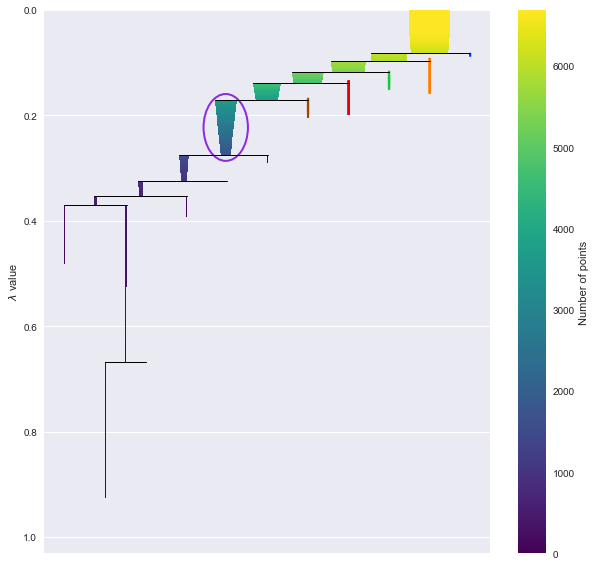

In [47]:
#dendogram of the clusters
# What is being circled? What are we looking at here?
%matplotlib inline
plt.figure(figsize=(10, 10))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('bright', 8))

In [53]:
# Changing index datafile used here, to fit Kevin's loops
school_data.index = school_data.iloc[:,0]
school_data = school_data.drop(columns=['INSTNM'])

In [54]:
#create empty lists and dataframes for all the clusters
cluster1 = []
cluster1_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster2 = []
cluster2_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster3 = []
cluster3_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster4 = []
cluster4_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster5 = []
cluster5_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster6 = []
cluster6_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster7 = []
cluster7_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster8 = []
cluster8_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))

#pull out the index of each cluster (school name)
for i in sorted_ClusterList:
    if i[0] == 0:
        cluster1.append(i[1])
    elif i[0] == 1:
        cluster2.append(i[1])
    elif i[0] == 2:
        cluster3.append(i[1])
    elif i[0] == 3:
        cluster4.append(i[1])
    elif i[0] == 4:
        cluster5.append(i[1])
    elif i[0] == 5:
        cluster6.append(i[1])
    elif i[0] == 6:
        cluster7.append(i[1])
    elif i[0] == 7:
        cluster8.append(i[1])
        
#pull in the desired elements for each school in a cluster and put it in a dataframe
for school in cluster1:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster1_df = cluster1_df.append(row)

for school in cluster2:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster2_df = cluster2_df.append(row)
    
for school in cluster3:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster3_df = cluster3_df.append(row)
    
for school in cluster4:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster4_df = cluster4_df.append(row)
    
for school in cluster5:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster5_df = cluster5_df.append(row)
    
for school in cluster6:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster6_df = cluster6_df.append(row)
    
for school in cluster7:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster7_df = cluster7_df.append(row)
    
for school in cluster8:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster8_df = cluster8_df.append(row)

In [55]:
avg_md_debt = (cluster1_df.GRAD_DEBT_MDN_SUPP.mean(), cluster2_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster3_df.GRAD_DEBT_MDN_SUPP.mean(),cluster4_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster5_df.GRAD_DEBT_MDN_SUPP.mean(),cluster6_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster7_df.GRAD_DEBT_MDN_SUPP.mean(),cluster8_df.GRAD_DEBT_MDN_SUPP.mean())
avg_md_earn = (cluster1_df.MD_EARN_WNE_P10.mean(),cluster2_df.MD_EARN_WNE_P10.mean(),
              cluster3_df.MD_EARN_WNE_P10.mean(),cluster4_df.MD_EARN_WNE_P10.mean(),
              cluster5_df.MD_EARN_WNE_P10.mean(),cluster6_df.MD_EARN_WNE_P10.mean(),
              cluster7_df.MD_EARN_WNE_P10.mean(),cluster8_df.MD_EARN_WNE_P10.mean())

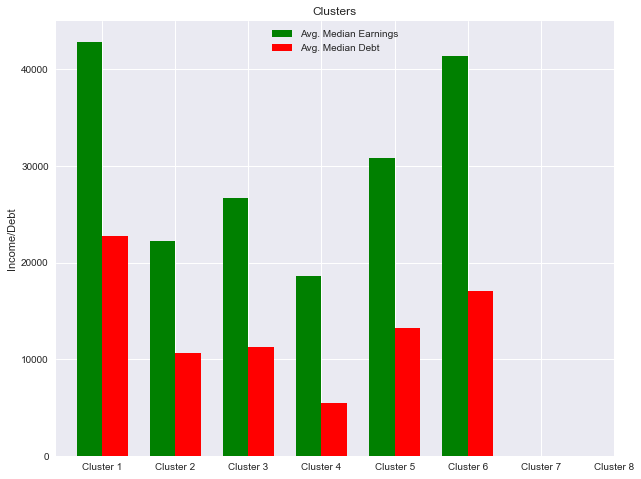

In [56]:
plt.figure(figsize=(10,8))

ind = np.arange(len(avg_md_earn)) 
width = 0.35       
plt.bar(ind, avg_md_earn, width, label='Avg. Median Earnings', color='g')
plt.bar(ind + width, avg_md_debt, width, label='Avg. Median Debt', color='r')

plt.ylabel('Income/Debt')
plt.title('Clusters')

plt.xticks(ind + width / 2, ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
                            'Cluster 7', 'Cluster 8'))
plt.legend(loc='best')
plt.show()

In [61]:
# Printing out the size of each cluster
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))
print(len(cluster4))
print(len(cluster5))
print(len(cluster6))
# Cluster sizes are very small with my data, only 1 main cluster, not good.

16
45
51
43
3665
36
